# Reconnaissance des feuilles pour la classification des plantes à l'aide du modèle «Bag of Words»

### Vue d'ensemble:

Dans ce travail, nous allons mettre sur pied un système d'apprentissage automatique pour le problème de la classification de plante. L'exercice nécessite des connaissances en programmation Python avec des bibliothèques: OpenCV, scikit-learn, pickle, numpy.

### Dataset
Le dataset utilisé pour ce travail est disponible via le lien suivant : http://flavia.sourceforge.net/

## Importation des bibliothèques

In [1]:
!pip install opencv-contrib-python==3.4.2.16

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import os
import pickle
from tqdm import tqdm
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Chargement des données

### Chargement des images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# La base de données comporte 32 classes, mais nous allons utiliser les 10 classes ayant le plus grand nombre d'images
# Ceci à cause de la limite en ressources matérielles

nbre_classe = 10

def get_label(image_name):
  i = int(image_name.split('.')[0])
  if i >= 1552 and i <= 1616:
    return 0
  elif i >= 1123 and i <= 1194:
    return 1
  elif i >= 1195 and i <= 1267:
    return 2
  elif i >= 2051 and i <= 2113:
    return 3
  elif i >= 2166 and i <= 2230:
    return 4
  elif i >= 2231 and i <= 2290:
    return 5
  elif i >= 2347 and i <= 2423:
    return 6
  elif i >= 2547 and i <= 2612:
    return 7
  elif i >= 3111 and i <= 3175:
    return 8
  elif i >= 3447 and i <= 3510:
    return 9
  else:
    return None

In [5]:
# Upload des images dans la variable liste_images
# Création du label de chaque image dans la variable y
# La ieme image du tableau liste_images correspond au ieme label du tableau y
# Si une image ne fait pas partie d'une des classes que nous voulons utiliser, nous l'ignorons

path_img = '/content/drive/My Drive/Dataset/Leaves/'

name_images = [ f for f in os.listdir(path_img) if os.path.isfile(os.path.join(path_img,f)) ]

liste_images = []
y = []

with tqdm(total=len(name_images), desc="Chargement des images", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
  for img in name_images:
    if img.split('.')[1] == 'jpg':
      l = get_label(img)
      if l is not None:
        image = cv.imread(os.path.join(path_img, img))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        liste_images.append(image)
        y.append(l)
    pbar.update(1)
print()
print("Nous avons un total de {} images".format(len(liste_images)))

Chargement des images: 100%|██████████ [ time left: 00:00 ]


Nous avons un total de 670 images


### Enrégistrement des labels

Nous allons maintenant mettre les étiquettes de chaque image comme décrit dans la source du dataset

In [6]:
# Création du tableau contenant les différentes valeurs de classe (10 classes [0 .. 9])
# L'index du tableau correspond au label
# La valeur du tableau correspond au nom commun

class_name = [" "] * nbre_classe

class_name[0] = "Anhui Barberry"
class_name[1] = "Chinese redbud"
class_name[2] = "true indigo"
class_name[3] = "Japanese cheesewood"
class_name[4] = "camphortree"
class_name[5] = "Japan Arrowwood"
class_name[6] = "deodar"
class_name[7] = "oleander"
class_name[8] = "Chinese Toon"
class_name[9] = "Canadian poplar"

## Data visualization

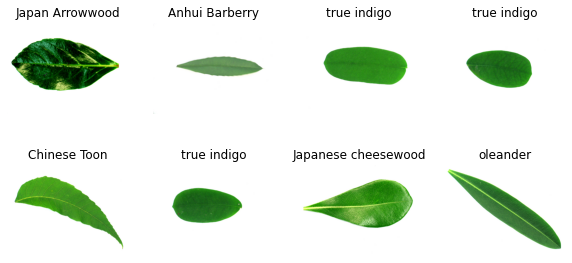

In [15]:
# Affichage de quelques images

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(len(liste_images), size=8)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(liste_images[i])
    plt.title('{}'.format(class_name[y[i]]))
    plt.axis("off")

### Décompte du nombre de classe

In [13]:
print("Nous avons {} classes dans notre dataset".format(len(np.unique(y))))

Nous avons 10 classes dans notre dataset


### Division des données en train et test

Nous division les données de la manière suivante:
- Train : 80%
- Test : 20%

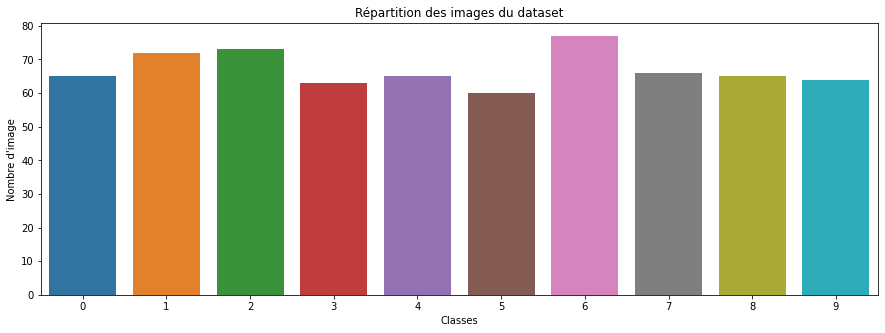

In [21]:
# Nombre d'images par classe dans toute la base de données
elements, repeats = np.unique(y, return_counts=True)

plt.figure(figsize=(15, 5))
plt.xlabel('Classes')
plt.ylabel('Nombre d\'image')
plt.title('Répartition des images du dataset')
sns.barplot(x=elements, y=repeats)

In [17]:
images_train, images_test, labels_train, labels_test = train_test_split(liste_images, y, test_size=0.2, random_state=42)

In [18]:
print("Images d'entrainemment : {}".format(len(images_train)))
print("Images de test : {}".format(len(images_test)))

Images d'entrainemment : 536
Images de test : 134


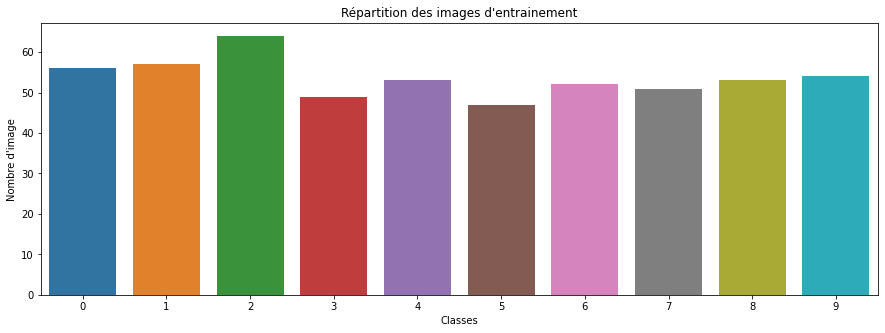

In [19]:
# Nombre d'images par classe dans les images d'entrainement
elements, repeats = np.unique(labels_train, return_counts=True)

plt.figure(figsize=(15, 5))
plt.xlabel('Classes')
plt.ylabel('Nombre d\'image')
plt.title('Répartition des images d\'entrainement')
sns.barplot(x=elements, y=repeats)

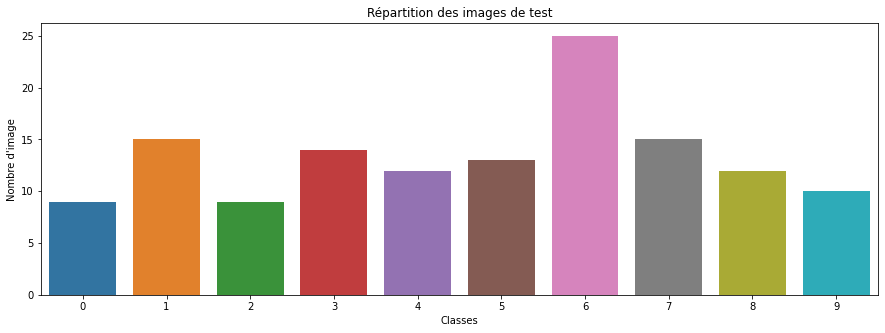

In [20]:
# Nombre d'images par classe dans les images de test
elements, repeats = np.unique(labels_test, return_counts=True)

plt.figure(figsize=(15, 5))
plt.xlabel('Classes')
plt.ylabel('Nombre d\'image')
plt.title('Répartition des images de test')
sns.barplot(x=elements, y=repeats)

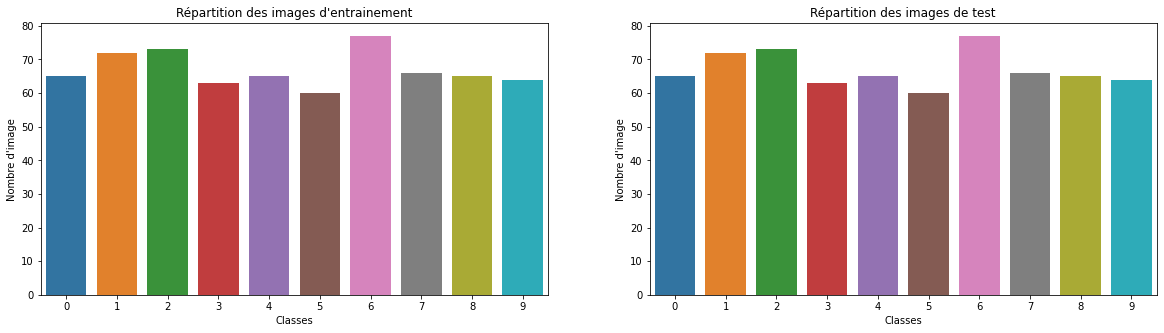

In [25]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 2, 1)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'image')
plt.title('Répartition des images d\'entrainement')
sns.barplot(x=elements, y=repeats)

ax = plt.subplot(1, 2, 2)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'image')
plt.title('Répartition des images de test')
sns.barplot(x=elements, y=repeats)

### Extraction des descripteurs SIFT

La fonction extract_sift_features() prend l'entrée de la liste d'images que nous avons créé et renvoie la liste image_descriptors, le kième élément de la liste image_descriptors est une liste contenant le descripteur de points clés SIFT correspondant à la kième image de la liste liste_image.

In [27]:
# Fonction pour extraire les desripteurs

def extract_sift_features(liste_image):
  image_descriptors = []
  image_key_point = []
  sift = cv.xfeatures2d.SIFT_create()
  with tqdm(total=len(liste_image), desc="Calcul des descripteurs", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for img in liste_image:
      gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
      kp, des = sift.detectAndCompute(gray, None)
      image_descriptors.append(des)
      image_key_point.append(kp)
      pbar.update(1)

  return image_descriptors, image_key_point

In [28]:
# Extraction des descripteurs dans les images d'entrainement

image_descriptors, image_keys_points = extract_sift_features(images_train)

Calcul des descripteurs: 100%|██████████ [ time left: 00:00 ]


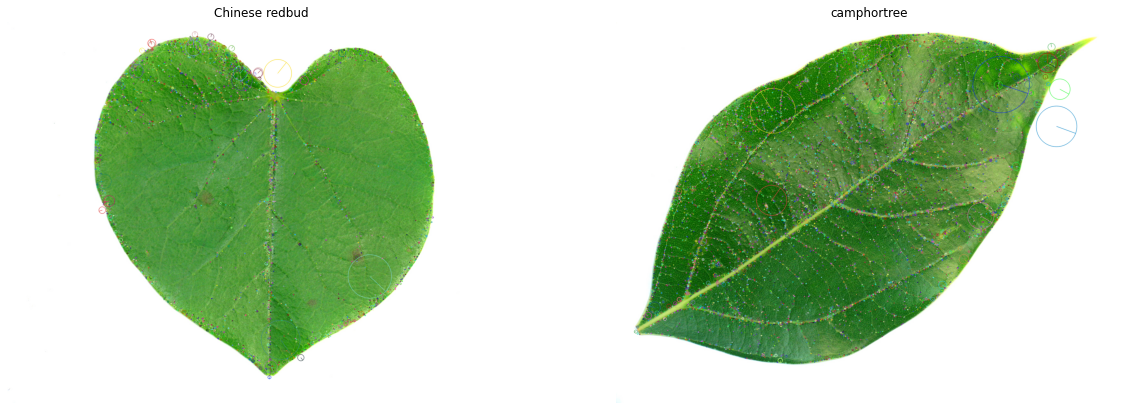

In [32]:
# Affichage de quelques images d'entrainement avec leurs points clés

plt.figure(figsize=(20, 20))
for k, i in np.ndenumerate(np.random.randint(len(images_train), size=2)):
    ax = plt.subplot(1, 2, k[0] + 1)
    plt.imshow(cv.drawKeypoints(images_train[i], image_keys_points[i], images_train[i].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.title('{}'.format(class_name[labels_train[i]]))
    plt.axis("off")

In [33]:
for i in range(10):
    print('Image {} possede {} descriptors'.format(i, len(image_descriptors[i])))

Image 0 possede 2290 descriptors
Image 1 possede 3562 descriptors
Image 2 possede 44 descriptors
Image 3 possede 334 descriptors
Image 4 possede 726 descriptors
Image 5 possede 514 descriptors
Image 6 possede 4372 descriptors
Image 7 possede 449 descriptors
Image 8 possede 689 descriptors
Image 9 possede 625 descriptors


## Construire un dictionnaire

La fonction kmeans_bow() prend en entrée la liste de tous les descripteurs des images de l'ensemble images_train et le nombre de clusters num_clusters, en utilisant l'algorithme KMeans de scikit-learn pour regrouper ces descripteurs vectoriels en cluster num_clusters. La fonction renvoie une liste des centre de clusters. Comme cette opération prend beaucoup de temps, nous enregistrerons la liste retournée par la fonction kmeans_bow() dans un fichier binaire (en utilisant la bibliothèque pickle) pour une utilisation plus facile plus tard.

In [34]:
# Construction de la liste des descripteurs

all_descriptors = []
for descriptors in image_descriptors:
  if descriptors is not None:
    for des in descriptors:
      all_descriptors.append(des)

print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 1233224


In [18]:
# Définition de la fonction kmeans_bow().

def kmeans_bow(all_descriptors, num_clusters):
  bow_dict = []
  kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
  bow_dict = kmeans.cluster_centers_
  return bow_dict

In [ ]:
# recherche du nombre de cluster avec la méthode Elbow

inertia = []
k_range = range(1, 10)
for k in k_range:
  model = KMeans(n_clusters=k).fit(all_descriptors)
  inertia.append(model.inertia_)

plt.plot(k_range, inertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût du model')
plt.show()

In [35]:
num_clusters = 96
if not os.path.isfile('bow_dictionary96.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)    
    pickle.dump(BoW, open('bow_dictionary96.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary96.pkl', 'rb'))
print(len(BoW))
print(len(BoW[0]))

96
128


### Construction des histogrammes de chaque image avec le modèle BoW obtenu

Construction de la fonction create_features_bow() qui prend la liste d'entrée image_descriptors, list_BoW et num_clusters, retourne la liste X_features, où le p-ième élément de X_vectors est un vecteur de caractéristiques du modèle BoW correspondant à la p-ième image, l'ensemble des descripteurs de points-clés. e p. Notez les éléments correspondants dans les quatre listes: X_tr, Y_tr, image_descriptors, X_features.

In [36]:
def create_histograms_bow(image_descriptors, BoW, num_clusters):
    X_histograms = []
    with tqdm(total=len(image_descriptors), desc="Création des histogrammes", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
      for i in range(len(image_descriptors)):
          histogram = np.array([0] * num_clusters) # <=> histogram=np.zeros(num_clusters,dtype=int)        
          if image_descriptors[i] is not None: # Il ya des descripteurs
              distance = cdist(image_descriptors[i], BoW) # Calcul de la distance  entre tous les descripteurs et les centroids        
              argmin = np.argmin(distance, axis=1) # Retourne les indices(centroid correspondant) des distances minimums pour chaque descripteur       
              for j in argmin: # On recupère le centroid de chaque descripteur
                  histogram[j] += 1 # On met à jour l'histogramme
          X_histograms.append(histogram)
          pbar.update(1)
    return X_histograms

#### Création de l'ensemble de formation basé sur un dictionnaire

In [37]:
# Données d'entrainement

image_descriptors, image_keys_points = extract_sift_features(images_train)
X_train = create_histograms_bow(image_descriptors, BoW, num_clusters)
X_train = np.array(X_train)
Y_train = np.array(labels_train)
print('Données d\'entraînement ')
print("train data: " + str(X_train.shape))
print("train label: " + str(Y_train.shape))

Calcul des descripteurs: 100%|██████████ [ time left: 00:00 ]
Création des histogrammes: 100%|██████████ [ time left: 00:00 ]

Données d'entraînement 
train data: (536, 96)
train label: (536,)


In [38]:
# Données de test

image_descriptors_test, image_keys_points_test = extract_sift_features(images_test)
X_test = create_histograms_bow(image_descriptors_test, BoW, num_clusters)
X_test = np.array(X_test)
Y_test = np.array(labels_test)
print('Données de test ')
print("test data: " + str(X_test.shape))
print("test label: " + str(Y_test.shape))

Calcul des descripteurs: 100%|██████████ [ time left: 00:00 ]
Création des histogrammes: 100%|██████████ [ time left: 00:00 ]

Données de test 
test data: (134, 96)
test label: (134,)


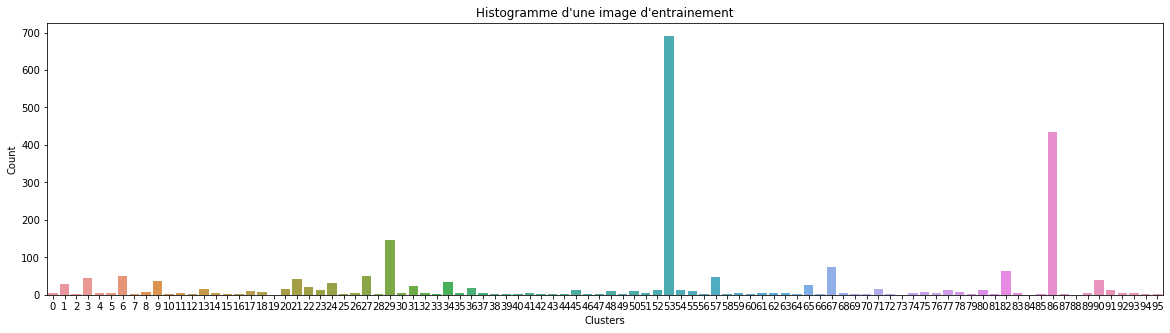

In [39]:
# Histogramme de la première image d'entrainement

plt.figure(figsize=(20, 5))
plt.xlabel('Clusters')
plt.ylabel('Count')
plt.title('Histogramme d\'une image d\'entrainement')
sns.barplot(x=[i for i in range(num_clusters)], y=X_train[0])

### Construire un modèle de classification basé sur des données nouvellement créées
Nous avons créé un vecteur de caractéristiques pour chaque image de l'ensemble de données. Dans cette question, nous allons construire des modèles de classification SVM

In [40]:
model_svm = make_pipeline(StandardScaler(), SVC())

params = {'svc__decision_function_shape': ['ovo', 'ovr'],
         'svc__gamma': ['auto', 'scale'],
         'svc__kernel': ['linear', 'rbf', 'poly'],
          'svc__C': [1, 0.5, 0.25, 0.025]}

grid = GridSearchCV(model_svm, params, cv=5)

print(model_svm)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


In [41]:
# Formation du modèle

grid.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            t

In [42]:
# Meilleurs paramètres

grid.best_params_

{'svc__C': 1,
 'svc__decision_function_shape': 'ovo',
 'svc__gamma': 'auto',
 'svc__kernel': 'linear'}

In [43]:
# Meileur score obtenu

grid.best_score_

0.9738663897542402

In [44]:
# Précision sur les données d'entrainement

grid.score(X_train, Y_train)

0.9925373134328358

In [45]:
# Précision sur les données de test

grid.score(X_test, Y_test)

0.9850746268656716

In [46]:
# Matrice de confusion sur les données de test
confusion = confusion_matrix(Y_test, grid.predict(X_test))
confusion

array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 13,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 24,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

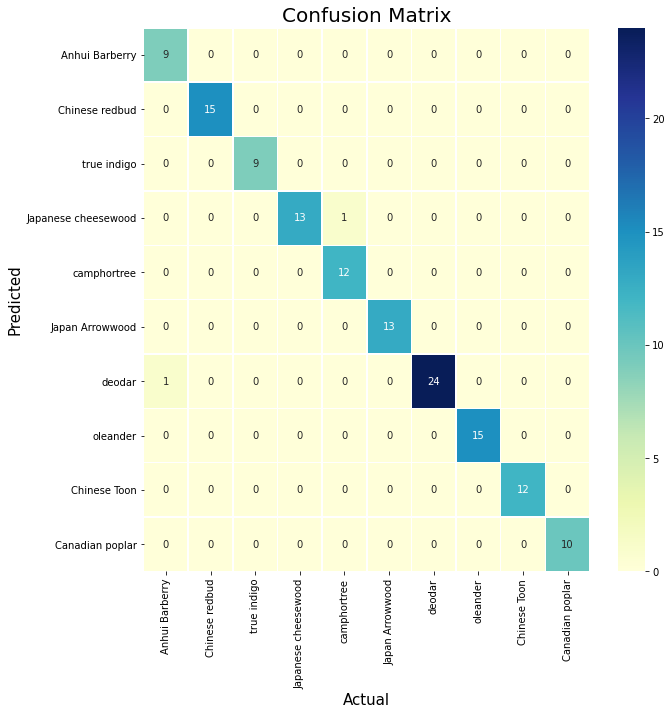

In [47]:
df_cm = pd.DataFrame(confusion, index = class_name,
              columns = class_name)

plt.figure(figsize = (10,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu", linewidths=.5)
plt.xlabel('Actual', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.show()

In [48]:
print(classification_report(Y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         9
           3       1.00      0.93      0.96        14
           4       0.92      1.00      0.96        12
           5       1.00      1.00      1.00        13
           6       1.00      0.96      0.98        25
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        10

    accuracy                           0.99       134
   macro avg       0.98      0.99      0.98       134
weighted avg       0.99      0.99      0.99       134



## Création d'une fonction de prédiction visuelle

In [62]:
def prédiction(image_path, BoW, num_clusters, svm):
  # Chargement de l'image
  img = cv.imread(image_path)
  img=cv.cvtColor(img, cv.COLOR_BGR2RGB)

  # Extraction des descripteurs
  x = [img]
  img_descriptors, img_keys_points = extract_sift_features(x)
  plt.imshow(cv.drawKeypoints(x[0], img_keys_points[0], x[0].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
  plt.title('Points clé de l\'image à prédire')
  plt.show()


  # Création de l'histogramme
  img_histogram = create_histograms_bow(img_descriptors, BoW, num_clusters)

  # On affiche l'histogramme
  plt.figure(figsize=(20, 5))
  plt.xlabel('Clusters')
  plt.ylabel('Count')
  plt.title('Histogramme de l\'image de test')
  sns.barplot(x=[i for i in range(num_clusters)], y=img_histogram[0])
  plt.show()

  # Prédiction du type de plante
  y_pred = grid.predict([img_histogram[0]])
  print()
  plt.imshow(img)
  plt.title('La classe prédite est : {}'.format(class_name[y_pred[0]]))
  plt.show()

Calcul des descripteurs: 100%|██████████ [ time left: 00:00 ]


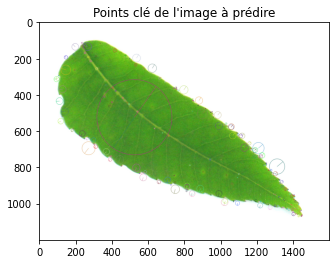

Création des histogrammes: 100%|██████████ [ time left: 00:00 ]


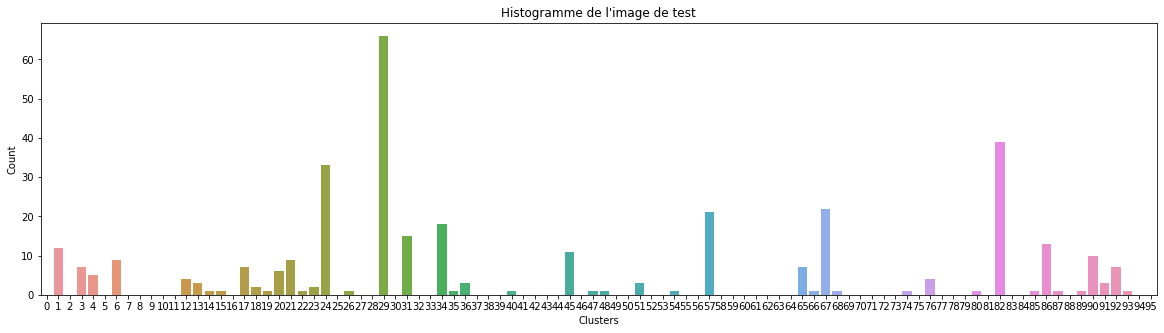

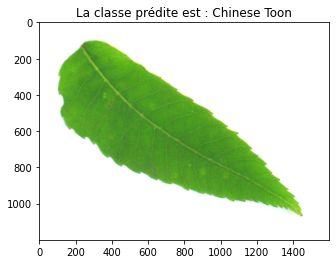

In [63]:
prédiction('/content/drive/MyDrive/Dataset/Leaves/3120.jpg', BoW, num_clusters, grid)